# 1. Setup

In [53]:
!pip install opencv-python matplotlib tensorflow==2.10

  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.1
    Uninstalling protobuf-4.23.1:
      Successfully uninstalled protobuf-4.23.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Owner\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



### Import Packages

In [25]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Input, Flatten
import tensorflow as tf

In [99]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
# run on Google Colab, no GPU ☹️

### Configure Directories

In [4]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [7]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. Collect Images

### Negative Image Database: http://vis-www.cs.umass.edu/lfw/


In [8]:
# Unzip Labeled Faces in the Wild dataset
!tar -xf lfw.tgz

In [9]:
# Move all LFW images to the "data\negative" directory
for directory in os.listdir("lfw"):
    for file in os.listdir(os.path.join("lfw", directory)):
        file_path = os.path.join("lfw", directory, file)
        new_path = os.path.join(NEG_PATH, file)
        os.replace(file_path, new_path)

### Collect Positive and Anchor Images using Camera

In [5]:
# UUID is used to generate unique file names for each image we collect
import uuid

In [19]:
# Connect to the webcam
video = cv2.VideoCapture(0)

while True:
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)
    
    # Resize the frame to 250x250x3 because all files must have the same dimensions as LFW images
    # Other numbers represent approximate face location
    frame = frame[115:115+250, 190:190+250, :]
    
    # Collect anchors when 'a' is pressed
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a unique file name
        img_path = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(img_path, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a unique file name
        img_path = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(img_path, frame)
    
    cv2.imshow("Video Feed", frame)
    
    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

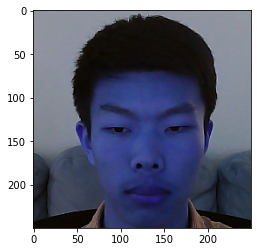

In [14]:
plt.imshow(frame)

### Data Augmentation

In [120]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

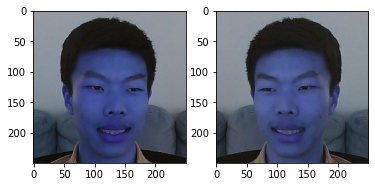

In [125]:
img_path = os.path.join(ANC_PATH, '000b8d17-f82d-11ed-9618-9cb6d0c97f20.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

plt.subplot(1,2,1)
plt.imshow(augmented_images[0])
plt.subplot(1,2,2)
plt.imshow(augmented_images[1])

# for image in augmented_images:
#     cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load Images


In [6]:
# Load images into TensorFlow Dataloader - 300 from directory
anchor = tf.data.Dataset.list_files(ANC_PATH + "\*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH + "\*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "\*.jpg").take(300)

In [7]:
anchor_test = anchor.as_numpy_iterator()
anchor_test.next()

b'data\\anchor\\eac879a9-f82c-11ed-b870-9cb6d0c97f20.jpg'

### Preprocess images

In [8]:
# Resize and scale images
def preprocess(file_path):
    # Read image from file path
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    # Resize image to 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image by dividing every value by 255
    img /= 255.0
    
    return img

In [30]:
# Sanity check
preprocess(b'data\\anchor\\eb828455-f82c-11ed-ad38-9cb6d0c97f20.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.63161767, 0.6002451 , 0.5884804 ],
        [0.63161767, 0.6009804 , 0.5889706 ],
        [0.62352943, 0.6039216 , 0.59117645],
        ...,
        [0.64387256, 0.6164216 , 0.59289217],
        [0.6431373 , 0.6127451 , 0.5980392 ],
        [0.64705884, 0.60784316, 0.6       ]],

       [[0.6370098 , 0.5977941 , 0.589951  ],
        [0.63553923, 0.5977941 , 0.5892157 ],
        [0.63259804, 0.5992647 , 0.59068626],
        ...,
        [0.6431373 , 0.6156863 , 0.5921569 ],
        [0.64485294, 0.61519605, 0.5982843 ],
        [0.6509804 , 0.6117647 , 0.6039216 ]],

       [[0.6375    , 0.5982843 , 0.59044117],
        [0.6392157 , 0.6       , 0.5921569 ],
        [0.63553923, 0.59632355, 0.5884804 ],
        ...,
        [0.6401961 , 0.6127451 , 0.58480394],
        [0.6463235 , 0.6188725 , 0.5953431 ],
        [0.6480392 , 0.6117647 , 0.595098  ]],

       ...,

       [[0.19681373, 0.15759803, 0.1377451 ],
        [0.21

### Label the Data

(anchor, positive) => 1,
(anchor, negative) => 0

In [9]:
positive_labels = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative_labels = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive_labels.concatenate(negative_labels)

In [10]:
sample_data = data.as_numpy_iterator().next()
sample_data

(b'data\\anchor\\03db0100-f82d-11ed-bd8f-9cb6d0c97f20.jpg',
 b'data\\positive\\65891631-f83d-11ed-a82f-9cb6d0c97f20.jpg',
 1.0)

### Partition Data into Train and Test groups

In [11]:
def link_pairs(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [35]:
match = link_pairs(*sample_data)

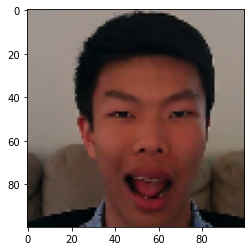

In [38]:
plt.imshow(match[1])

In [12]:
# Building the data pipeline
data = data.map(link_pairs)
data = data.cache()
data = data.shuffle(buffer_size=1024)

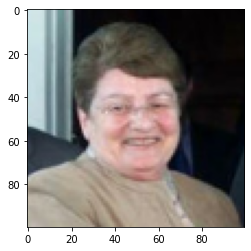

In [47]:
sample = data.as_numpy_iterator()
plt.imshow(sample.next()[1])

In [13]:
# Training partition - 70% of data
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [14]:
# Testing partition - 30% of data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Build the Model!

### Create Embedding 

In [15]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name="input_image")
    
    # Block 1
    conv1 = Conv2D(64, (10,10), activation="relu")(inp)
    mp1 = MaxPooling2D(64, (2,2), padding="same")(conv1)
    
    # Block 2
    conv2 = Conv2D(128, (7,7), activation="relu")(mp1)
    mp2 = MaxPooling2D(64, (2,2), padding="same")(conv2)
    
    # Block 3
    conv3 = Conv2D(128, (4,4), activation="relu")(mp2)
    mp3 = MaxPooling2D(64, (2,2), padding="same")(conv3)
    
    # Block 4
    conv4 = Conv2D(256, (4,4), activation="relu")(mp3)
    # Transform into the 4096 length fully-connected layer
    f1 = Flatten()(conv4)
    d1 = Dense(4096, activation="sigmoid")(f1)
    
    return Model(inputs=[inp], outputs=[d1], name="embedding")

In [16]:
embedding_model = make_embedding()
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Create Distance Layer

In [17]:
class L1Dist(Layer):
    # Inheritance of the Layer class
    def __init__(self, **kwargs):
        super().__init__()
    
    # Calculate distance (similarity)
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [18]:
l1 = L1Dist()
l1

### Create Siamese Model

In [32]:
def make_siamese_model():
    input_img = Input(name="input_img", shape=(100,100,3))
    validation_img = Input(name="validation_img", shape=(100,100,3))
    
    # Combine the distances
    distance_layer = L1Dist()
    distance_layer._name = "distance"
    distances = distance_layer(embedding_model(input_img), embedding_model(validation_img))
    
    # Classification layer: 4096 -> 1
    classifier = Dense(1, activation="sigmoid")(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=classifier, name="SiameseNetwork")

In [34]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Model Training

### Create Loss Function and Optimizer

In [28]:
# Using Binary Cross-Entropy Loss
loss_function = tf.losses.BinaryCrossentropy()
# Adam optimizer - an extension of Stochastic Gradient Descent
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

### Establish Checkpoints

In [22]:
checkpoint_dir = "./training_checkpoints"
# os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "cpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Training Step

In [29]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        imgs = batch[:2]
        labels = batch[2]
        
        # Forward pass
        predicted_labels = siamese_model(imgs, training=True)
        # Calculate loss
        loss = loss_function(labels, predicted_labels)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Backpropagation 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

### Training Loop


In [38]:
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print("Epoch {}/{}".format(epoch, epochs))
        progress_bar = tf.keras.utils.Progbar(len(train_data))
        
        # Loop through each batch
        for index, batch in enumerate(data):
            loss = train_step(batch)
            progress_bar.update(index+1)
        
        print(loss.numpy())
        print()
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the Model

In [59]:
epochs = 50
train(train_data, epochs)

Epoch 1/50
27/27 [==============================] - 593s 22s/step
0.43880916

Epoch 2/50
27/27 [==============================] - 593s 22s/step
0.085534856

Epoch 3/50
23/27 [========================>.....] - ETA: 1:31

KeyboardInterrupt: 

# 6. Evaluate Model

In [60]:
# Import Precision and Recall
# Precision is what proportion of positive identifications are correct
# Recall is what proportion of actual positives are identified correctly
from tensorflow.keras.metrics import Precision, Recall

### Make Predictions

In [61]:
# Get a batch of test data
test_input, test_validation, labels = test_data.as_numpy_iterator().next()

In [62]:
# Make predictions
prediction = siamese_model.predict([test_input, test_validation])
prediction

C:\Users\Owner\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 754ms/step


array([[7.52828658e-01],
       [9.09774303e-01],
       [1.92575285e-03],
       [1.45870075e-03],
       [1.34828955e-01],
       [6.19647326e-04],
       [5.00177091e-04],
       [2.62316840e-04],
       [1.08837536e-04],
       [9.99767721e-01],
       [9.99925375e-01],
       [6.79333627e-01],
       [1.54411959e-04],
       [9.99751031e-01],
       [7.34249537e-04],
       [3.04381433e-03]], dtype=float32)

In [63]:
# List comprehension
[1 if pred > 0.5 else 0 for pred in prediction]

[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]

In [64]:
labels

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

### Calculate Metrics

In [119]:
r = Recall()
p = Precision()

for test_input, test_validation, labels in test_data.as_numpy_iterator():
    prediction = siamese_model([test_input, test_validation])
    r.update_state(labels, prediction)
    p.update_state(labels, prediction)

print(r.result().numpy(), p.result().numpy())
# 98.9 % of true positives are identified correctly, and 100% of positive identifications are true positives

0.98888886 1.0


### Visualize Results

1.0


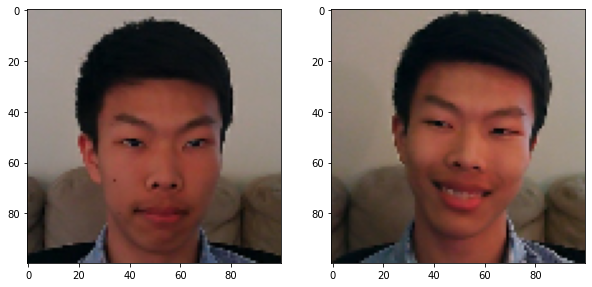

In [81]:
i = 9
plt.figure(figsize=(10, 8))

# Show Anchor image
plt.subplot(1, 2, 1)
plt.imshow(test_input[i])

# Show Positive/Negative image
plt.subplot(1, 2, 2)
plt.imshow(test_validation[i])

print(labels[i])
plt.show()

# 7. Save Model

In [ ]:
# Save weights
siamese_model.save("siamesemodel.h5")

In [82]:
# Reload model
model = tf.keras.models.load_model("siamesemodel.h5", 
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [83]:
model.predict([test_input, test_validation])

C:\Users\Owner\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 675ms/step


array([[9.9999535e-01],
       [8.0774206e-01],
       [6.3550215e-06],
       [1.9029653e-08],
       [2.4276217e-10],
       [1.6720240e-10],
       [1.0729127e-08],
       [2.5400058e-09],
       [2.5782623e-10],
       [1.0000000e+00],
       [9.9963933e-01],
       [9.9999982e-01],
       [1.5458108e-08],
       [1.0000000e+00],
       [5.8585609e-08],
       [5.7663767e-09]], dtype=float32)

In [84]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Full Test

### Verification Function

In [107]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))
        
        # Make Predictions
        result = model(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Calculate the proportion of predicted results that are positive
    detection_total = np.sum(np.array(results) > detection_threshold)
    verification = detection_total/len(os.listdir(os.path.join("application_data", "verification_images")))
    verdict = verification > verification_threshold
    
    return results, verdict

### OpenCV Verification

In [114]:
video = cv2.VideoCapture(0)

while video.isOpened():
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)

    frame = frame[115:115+250, 190:190+250, :]
    
    cv2.imshow("Verification", frame)
    
    # Do verification
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to input_image folder
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
        
        # Run verification
        results, verdict = verify(model, 0.5, 0.5)
        print(verdict)
        
    # Exit loop
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

True


In [113]:
np.squeeze(results)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999857,
       1.        , 1.        , 1.        , 1.        , 0.9998423 ,
       0.9999996 , 0.9999991 , 0.9999996 , 0.9999999 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)